# RNA-Seq Analysis

In [1]:
import copy
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import svd
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'array_metadata.tsv')
array_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0, squeeze=True)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

tpm = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv'), index_col=0,
                                 low_memory=False)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'star_logs.tsv')
star_logs = pd.read_table(fn, index_col=0)

## STAR Logs

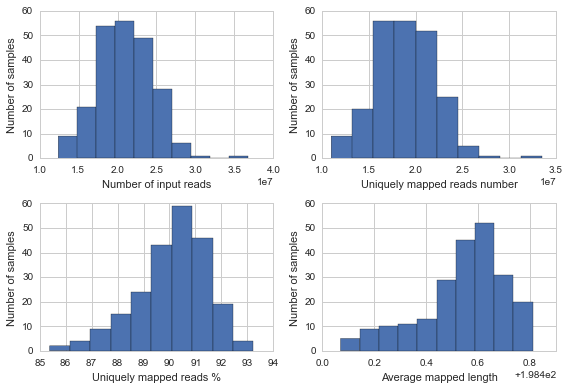

In [4]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
ax = axs[0]
k = 'Number of input reads'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
ax = axs[1]
k = 'Uniquely mapped reads number'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
ax = axs[2]
k = 'Uniquely mapped reads %'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
ax = axs[3]
k = 'Average mapped length'
star_logs[k].hist(ax=ax)
ax.set_ylabel('Number of samples')
ax.set_xlabel(k)
plt.tight_layout()

## Expression Distribution

225    20653
0      15212
dtype: int64


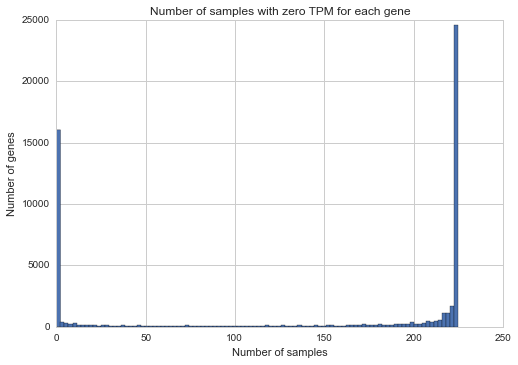

In [5]:
s = (tpm == 0).sum(axis=1)
print(s.value_counts().head(2))
s.hist(bins=100)
plt.title('Number of samples with zero TPM for each gene')
plt.ylabel('Number of genes')
plt.xlabel('Number of samples');

We can see overal that there are a fair number of genes that are not expressed
in any samples.

0      13548
225      955
dtype: int64


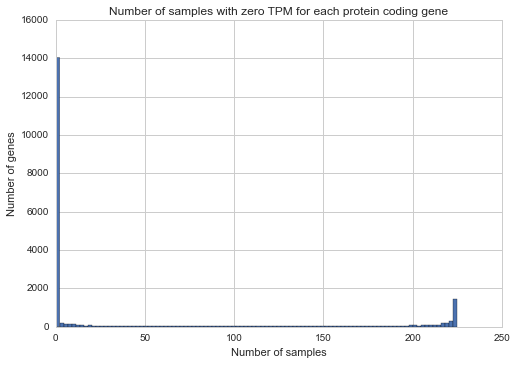

In [6]:
s = (tpm[gene_info.ix[tpm.index, 'gene_type'] == 'protein_coding'] == 0).sum(axis=1)
print(s.value_counts().head(2))
s.hist(bins=100)
plt.title('Number of samples with zero TPM for each protein coding gene')
plt.ylabel('Number of genes')
plt.xlabel('Number of samples');

Protein coding genes are highly enriched for being expressed in all samples.

## Clustering

In [7]:
# Filter for robustly expressed genes and take log.
tpm_f = tpm[(tpm == 0).sum(axis=1) == 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

In [8]:
cov = log_tpm.std(axis=1) / log_tpm.mean(axis=1)
cov.sort(ascending=False)

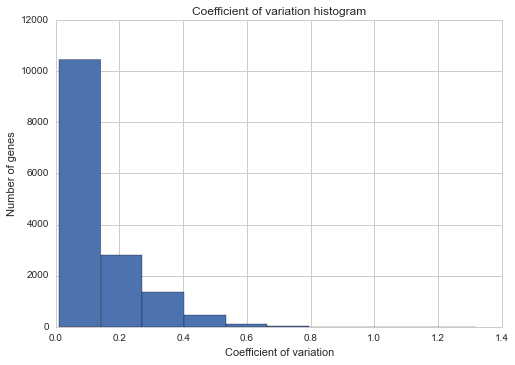

In [9]:
cov.hist()
plt.title('Coefficient of variation histogram')
plt.xlabel('Coefficient of variation')
plt.ylabel('Number of genes');

In [10]:
genes = [x.split('.')[0] for x in cov.index]
sig = np.array([False] * len(genes))
sig[0:1000] = True

In [11]:
var_go_results = cpb.analysis.goseq_gene_enrichment(genes, sig)

Loading required package: BiasedUrn
Loading required package: geneLenDataBase
Loading required package: DBI
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unli

In [12]:
var_go_results.head()

,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_pvalue_bh,under_represented_pvalue_bh
category,,,,,,,,
GO:0005886,9.196636e-33,1,296,2794,plasma membrane,CC,1.589455e-28,1
GO:0071944,3.571842e-32,1,300,2872,cell periphery,CC,3.086608e-28,1
GO:0032501,1.708601e-27,1,376,4237,multicellular organismal process,BP,9.843249e-24,1
GO:0044707,2.650160e-27,1,368,4108,single-multicellular organism process,BP,1.145068e-23,1
GO:0044459,6.651086e-26,1,178,1415,plasma membrane part,CC,2.299014e-22,1


In [13]:
meta = rna_meta.merge(subject_meta, left_on='subject_id', 
                      right_index=True, how='outer')

In [14]:
color_meta = pd.DataFrame(index=meta.index)
color_meta['sex'] = [(1, 1, 1)] * color_meta.shape[0]
ind = meta[meta.sex == 'M'].index
color_meta.ix[ind, 'sex'] = [sns.color_palette()[0]] * ind.shape[0]
cdict = dict(zip(set(meta.sequence_id), sns.color_palette()[1:4]))
color_meta['sequence_id'] = [cdict[x] for x in meta.sequence_id]
cdict = dict(zip(set(meta.estimated_ethnicity), sns.color_palette("Set2", 5)))
color_meta['estimated_ethnicity'] = [cdict[x] for x in meta.estimated_ethnicity]
cdict = dict(zip(set(meta.family_id), len(set(meta.family_id)) * [(1, 1, 1)]))
for i, k in enumerate(meta.family_id.value_counts().head(8).index):
    cdict[k] = sns.color_palette('Set1', 8)[i]
cdict[np.nan] = (1, 1, 1)
color_meta['family_id'] = [cdict[x] for x in meta.family_id]

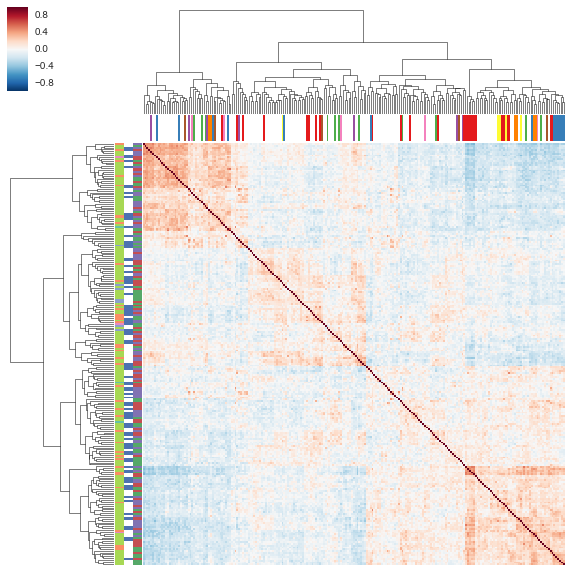

In [15]:
t = log_tpm_n.ix[cov.head(500).index]
ct = t.corr(method='spearman')
cg = sns.clustermap(
    ct, xticklabels=False, yticklabels=False,
    row_colors=color_meta.ix[ct.index, ['estimated_ethnicity', 'sex', 'sequence_id']].T.values,
    col_colors=color_meta.ix[ct.index, ['family_id']].T.values)

## SVD

In [16]:
res = cpb.analysis.SVD(log_tpm, scale_variance=True)

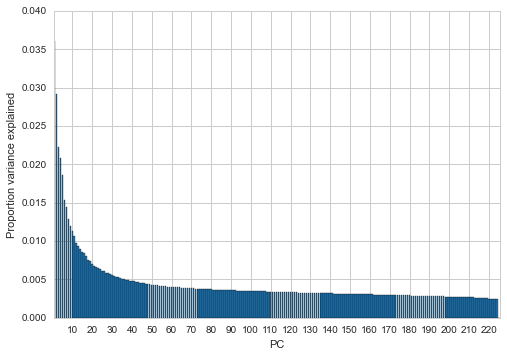

In [17]:
res.plot_variance_explained(xtick_start=10, xtick_spacing=10, cumulative=False)

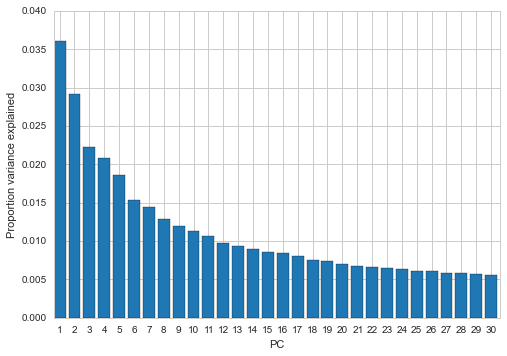

In [18]:
res.plot_variance_explained(num_pc=30)

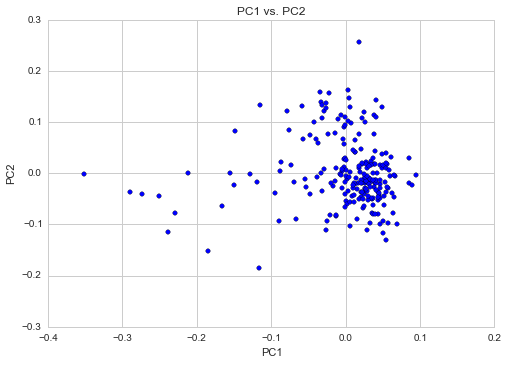

In [19]:
res.plot_pc_scatter('PC1', 'PC2');

In [20]:
pc_anova = res.pc_anova(meta[['sex', 'estimated_ethnicity', 'sequence_id']])
pc_anova.pvalue

,PC1,PC2,PC3,PC4,PC5
sex,0.309492,0.022614,0.012985,0.105605,0.700452
estimated_ethnicity,0.056147,0.957606,0.519894,0.444732,0.482999
sequence_id,0.010188,0.071707,0.004343,0.000094,0.970465


## Correlation with Covariates

In [28]:
def transform_standard_normal(df):
    gc_ranks = df.rank(axis=1)
    gc_ranks = gc_ranks / (gc_ranks.shape[1] + 1)
    std_norm = stats.norm.ppf(gc_ranks)
    std_norm = pd.DataFrame(std_norm, index=gc_ranks.index, 
                            columns=gc_ranks.columns)
    return std_norm

In [29]:
std_norm_tpm = transform_standard_normal(log_tpm)

In [27]:
tdf = subject_meta[subject_meta.estimated_ethnicity == 'EUR']
a = tdf[tdf.family_id.isnull()]
b = tdf.dropna(subset=['family_id'])
b = b.drop_duplicates(subset=['family_id'])
tdf = pd.concat([a, b])
print('Number to use for covariate correlation: {}'.format(tdf.shape[0]))

Number to use for covariate correlation: 87


In [86]:
lm_cov = copy.deepcopy(rna_meta)
lm_cov = lm_cov.merge(tdf, left_on='subject_id', right_index=True)
lm_cov = lm_cov[['passage', 'sex', 'age', 'sequence_id']]
lm_cov['sequence_id'] = lm_cov.sequence_id.astype(str)
#lm_cov = pd.get_dummies(data=lm_cov, columns=['sequence_id']).drop('sequence_id_6', axis=1)
lm_data = lm_cov.join(std_norm_tpm.T)
lm_data.columns = [x.replace('.', '_') for x in lm_data.columns]

In [89]:
pvalues = pd.DataFrame(
    [results[k].pvalues for k in results.keys()],
    index=[x.replace('_', '.') for x in results.keys()])

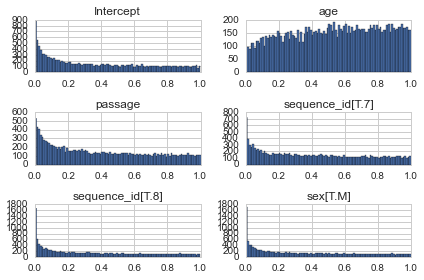

In [107]:
pvalues.hist(bins=100)
plt.tight_layout();

In [109]:
%%R

library(qvalue)

In [127]:
pvals = pvalues['sex[T.M]']

In [128]:
%%R -i pvals -o qvalues,pi0,lfdr,sig

qobj = qvalue(p=pvals, fdr.level=0.05)
qvalues <- qobj$qvalues
pi0 <- qobj$pi0
lfdr <- qobj$lfdr
sig <- qobj$significant

summary(qobj)


Call:
qvalue(p = pvals, fdr.level = 0.05)

pi0:	0.6216436	

Cumulative number of significant calls:

        <1e-04 <0.001 <0.01 <0.025 <0.05 <0.1    <1
p-value    368    698  1711   2509  3411 4674 15251
q-value    197    299   599   1033  1563 2601 15251



In [129]:
qvalue_res = pd.DataFrame([list(pvals), list(qvalues), list(sig)], 
                          index=['pvalue', 'qvalue', 'sig'],
                          columns=pvals.index).T
qvalue_res = qvalue_res.sort(['qvalue'])

In [134]:
gene_info.ix[qvalue_res[qvalue_res.sig].index]['chrom'].value_counts()

chrX     259
chr1     147
chr19    104
chr11     86
chr2      85
chr17     76
chr12     74
chr16     67
chr6      66
chr5      65
chr7      65
chr3      64
chr4      52
chr10     47
chr8      45
chr15     43
chr14     40
chr9      40
chr22     40
chr20     37
chr18     24
chr13     22
chr21     14
chrY       1
dtype: int64

In [ ]:
res = cpb.analysis.SVD(log_tpm, scale_variance=True)